In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import squidpy as sq
import anndata as ad

import pickle

 

/nfs/team361/aa36/PythonEnvs_2/envinflowdec27/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


In [ ]:
# import sys
# !{sys.executable} -m pip install spatialdata_io

In [3]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
#%matplotlib inline
sc.settings.figdir = "fig1"
sc.settings.set_figure_params(dpi_save=300, facecolor="white", frameon=False, figsize=(8,8))


# Latest

In [4]:
FILE_NAME = "adata_combined_new.h5ad.final.filtered"
PATH2=f'/nfs/team298/ls34/adult_skin/final_adatas/{FILE_NAME}'
adata_5k=sc.read_h5ad(PATH2)
adata_5k=adata_5k[adata_5k.obs["tech"]=="xenium"]
# adata_5k.obs["Timepoint2"].value_counts()
#adata_5k=sc.read_h5ad('/nfs/team298/ls34/adult_skin/final_adatas/adata_xenium_v1.h5ad.final')
def remove_markers(LIST):
    try: 
        LIST = {key: [gene for gene in genes if gene in adata_5k.var_names] 
                           for key, genes in LIST.items()}
    except: 
        LIST =[gene for gene in LIST if gene in adata_5k.var_names]
    return LIST


 

View of AnnData object with n_obs × n_vars = 1418806 × 4993
    obs: 'sample_id', 'barcode', 'GSE', 'Site_status', 'Patient_status', 'Location', 'Age', 'Sex', 'n_genes', 'dataset_id', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'QC_hi', 'QC_mid', 'lvl5_annotation', 'Mapping_status', 'scanvi_predictions', 'lvl5_annotation_new', 'lvl5_annotation_new2', 'lvl5_annotation_new3', 'lvl5_annotation_new_archive', 'lvl5_annotation_new_preoprhan', 'lvl5_annotation_new10', 'lvl5_annotation_new11', 'test', 'test_n', 'lvl5_annotation_new12', 'lvl5_annotation_new13', 'lvl4_annotation', 'lvl0', 'temp', 't', 'leiden_res0.1', 'Site_status_simple', 'StatusMilo', 'atlas_status', 'atlas_status_reynolds', 'atlas_status_reynolds_simple', 'atlas_status_simple', 'atlas_status_simple2', 'Site_status_binary', 'scanvi_labels

In [5]:
adata_5k.obs["Site_status"].value_counts()

Site_status
Non-lesional                        365837
Lesional                            231621
3D_Week12                           180311
3D_Lesional_baseline                153479
Week 12                             139631
Psoriasis_replicate_non-lesional     76048
Week 8 Psoriasis                     72094
Psoriasis_replicate_Lesional         60647
Healthy                              59315
Psoriasis_replicate_PostRx           49385
Day 14_HF                            30438
Name: count, dtype: int64

In [6]:
counts = adata_5k.obs["niche19"].value_counts()

keep = counts[counts > 10].index

adata_5k =adata_5k[adata_5k.obs["niche19"].isin(keep)]
adata_5k.obs["niche19"].value_counts()
adata_5k = adata_5k[adata_5k.obs["niche19"]!="Nonspecific/folded"]

In [ ]:
import pickle

path = "/nfs/team298/ls34/niche_colors.pkl"

# Load the dictionary
with open(path, "rb") as f:
    colors_new2 = pickle.load(f)
colors=colors_new2

# 5a: Lesional

In [7]:
adata_5k_lesional = adata_5k[adata_5k.obs["Site_status"].isin(["Lesional","3D_Lesional_baseline",
                                                               'Psoriasis_replicate_Lesional',
                                                               'Psoriasis_replicate_PostRx'
                                                      ])]

/tmp/ipykernel_1817987/3438314501.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_5k_lesional.obs.groupby(["niche19", "info_id6"])
/tmp/ipykernel_1817987/3438314501.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ct.groupby("niche19")["info_id6"]
/tmp/ipykernel_1817987/3438314501.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(donor_counts.index, rotation=90, ha="right", fontsize=12)


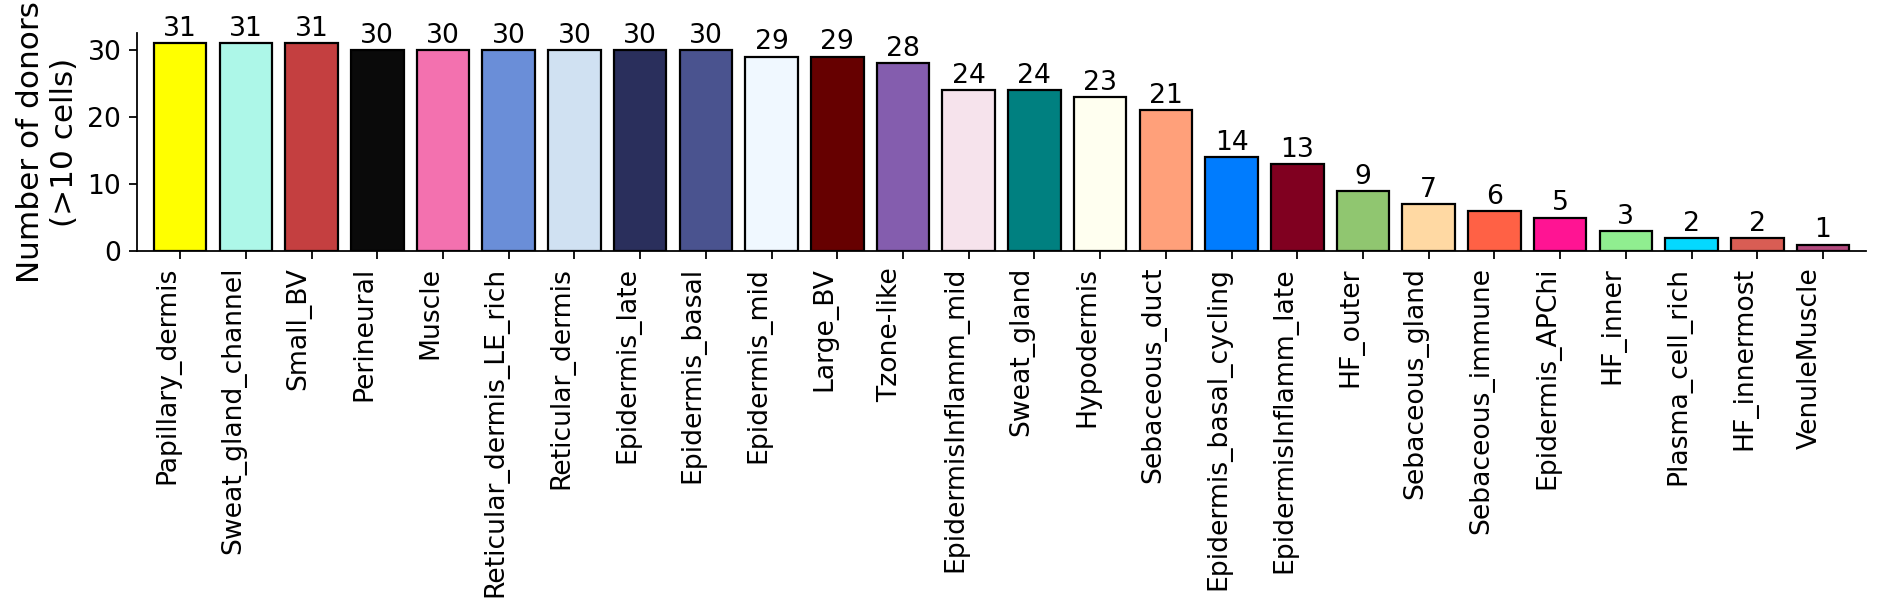

In [10]:
ct = (
    adata_5k_lesional.obs.groupby(["niche19", "info_id6"])
               .size()
               .reset_index(name="cells")
)

ct = ct[ct["cells"] > 10]

donor_counts = (
    ct.groupby("niche19")["info_id6"]
      .nunique()
      .sort_values(ascending=False)
)

bar_colors = [colors.get(n, "grey") for n in donor_counts.index]

fig, ax = plt.subplots(figsize=(12, 4))

ax.bar(
    donor_counts.index,
    donor_counts.values,
    color=bar_colors,
    edgecolor="black"
)

for x, y in zip(donor_counts.index, donor_counts.values):
    ax.text(x, y + 0.2, str(y), ha="center", va="bottom", fontsize=12)

plt.margins(x=0.01)

ax.set_ylabel("Number of donors\n(>10 cells)", fontsize=14)
ax.set_xlabel("")  # remove x-label
ax.set_title("", fontsize=16)
ax.set_xticklabels(donor_counts.index, rotation=90, ha="right", fontsize=12)
ax.tick_params(axis='y', labelsize=12)

ax.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.savefig("fig3/supp5a_lesional.pdf", dpi=300, bbox_inches="tight")

plt.show()

# 5a: week 12

In [ ]:
adata_5k_w12 = adata_5k[adata_5k.obs["Site_status"].isin(["Week 8/12",
                                                         "Week 12",
                                                         ])]

/tmp/ipykernel_1817987/2531142493.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_5k_w12.obs.groupby(["niche19", "info_id6"])
/tmp/ipykernel_1817987/2531142493.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ct.groupby("niche19")["info_id6"]
/tmp/ipykernel_1817987/2531142493.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(donor_counts.index, rotation=90, ha="right", fontsize=12)


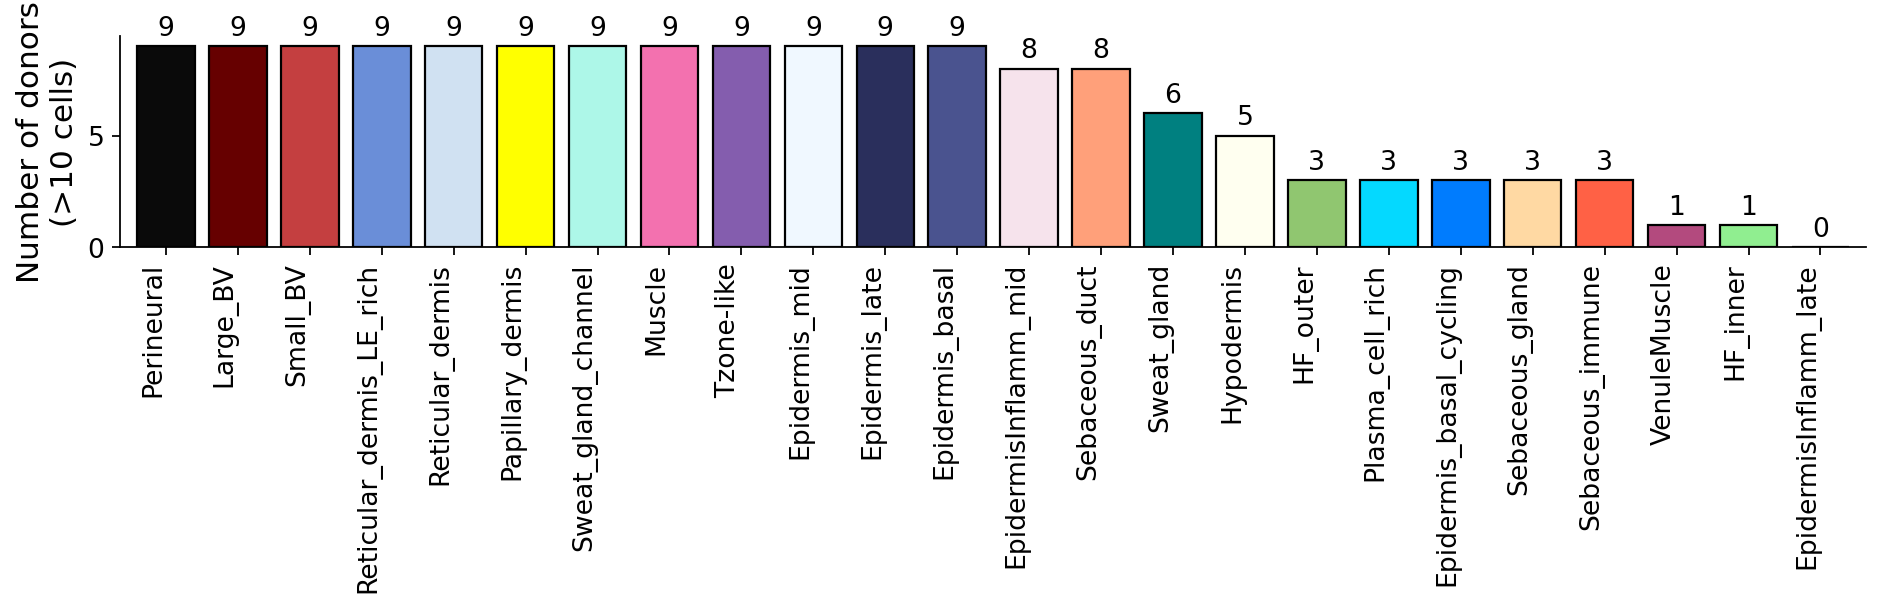

In [ ]:
# ─────────────────────────────────────────────────────────────
# 1 · Count donors (>10 cells) per niche
# ─────────────────────────────────────────────────────────────
ct = (
    adata_5k_w12.obs.groupby(["niche19", "info_id6"])
               .size()
               .reset_index(name="cells")
)

# keep donor–niche combos with >10 cells
ct = ct[ct["cells"] > 10]

# number of donors per niche
donor_counts = (
    ct.groupby("niche19")["info_id6"]
      .nunique()
      .sort_values(ascending=False)
)

# colours
bar_colors = [colors.get(n, "grey") for n in donor_counts.index]

# ─────────────────────────────────────────────────────────────
# 2 · Bar chart
# ─────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 4))

ax.bar(
    donor_counts.index,
    donor_counts.values,
    color=bar_colors,
    edgecolor="black"
)

# label bars
for x, y in zip(donor_counts.index, donor_counts.values):
    ax.text(x, y + 0.2, str(y), ha="center", va="bottom", fontsize=12)

# remove extra whitespace between y-axis and first bar
plt.margins(x=0.01)

# tidy up labels and appearance
ax.set_ylabel("Number of donors\n(>10 cells)", fontsize=14)
ax.set_xlabel("")  # remove x-label
ax.set_title("", fontsize=16)
ax.set_xticklabels(donor_counts.index, rotation=90, ha="right", fontsize=12)
ax.tick_params(axis='y', labelsize=12)

# remove junk
ax.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.savefig("fig3/supp5a_week12.pdf", dpi=300, bbox_inches="tight")

plt.show()

In [ ]:
1

1